# InSight : Market Visualizer

## Introduction: 

### Abstract

The aim of this project is to present market data in a way which is optimum for research and distribution. 

### Technology used

* Python 3.2 
* NASDAQ Realtime Stock Streaming API 
* The New York Times Article Search API 
* JSON 
* Plotly 
* Jupyter Notebooks 

### Benefits and Potential Impacts

InSight provides a superior way to view and analyze data, by cutting down on research time and using a powerful algorithm to predict important instances in both past and present data. 
It harnesses the power of the New York Times and helps the user to establish connections between the Financial World and the Real World. 
The engine is powerful enough to go beyond financial data and analyze to high accuracy, any data that can be quantified. 

## Visualizations and Code

In [1]:
#All the libraries used. 
from datascience import *
import datetime as dt
import pandas as pd
import numpy as np
import websocket
import threading
import argparse
import time
import json
import requests
from time import sleep



# These lines set up graphing capabilities.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
#This command runs the API and generates a '.csv' file of the data for processing. 
%run nasdaq.py --start_date 20160101 --end_date 20170202 --symbols AAPL

--- request header ---
GET /stream?symbol=AAPL&start=20160101&end=20170202 HTTP/1.1
Upgrade: websocket
Connection: Upgrade
Host: 34.214.11.52
Origin: http://34.214.11.52
Sec-WebSocket-Key: XA5q6iwSesVxkbYMuTPcJg==
Sec-WebSocket-Version: 13


-----------------------
--- response header ---
HTTP/1.1 101 Switching Protocols
Content-Length: 0
Upgrade: websocket
Sec-Websocket-Accept: ntLqnwFAo0GM4UaAGBhYz0qfepw=
Server: TornadoServer/4.5.1
Connection: Upgrade
Date: Sun, 08 Oct 2017 13:18:10 GMT
-----------------------
send: b'\x81\x80\x06\xf3\x9a\xf6'
send: b'\x88\x82\xa8\xd5g\xb1\xab='


### closed ###


In [3]:
#Documenting the initial conditions. 
start = '20160101'
end = '20170202'
company = 'AAPL'

#Gets the name of the company from a database of company names and codes. 
def getCompany(comp): 
    comp_tab = Table.read_table('companylist.csv')
    return comp_tab.where(0, comp).column(1).item(0)

In [4]:
#Takes the "nasdata.csv" file and generates a table with useful information (Can be altered by the user).
raw_data = (Table.read_table("nasdata.csv")).drop(0)

In [5]:
#Function that helps to get the required date format for The NY Times. 
def getDate(date): 
    date=str(date)
    return date[0:10].replace("-", "")
def addOne(date): 
    return getDate(str((pd.to_datetime(date) + dt.timedelta(days=1))))

In [6]:
#Takes particular values from "raw_data" to join with the NY Times data
nyData = Table().with_columns("Date", raw_data.apply(getDate, 1), "NextDate", raw_data.apply(addOne, 1) , "High", raw_data.column("High"), "Low", raw_data.column("Low"), "Close", raw_data.column("Close"))

In [7]:
nasvizData = Table().with_columns("Date", pd.to_datetime(raw_data.column(1)), "High", raw_data.column("High"), "Low", raw_data.column("Low"), "Close", raw_data.column("Close"))

In [8]:
nasvizData

Date,High,Low,Close
2016-01-05 00:00:00,105.85,102.41,102.71
2016-01-06 00:00:00,104.144,99.87,100.7
2016-01-07 00:00:00,104.09,96.43,96.45
2016-01-08 00:00:00,99.11,96.76,96.96
2016-01-11 00:00:00,99.06,97.34,98.53
2016-01-12 00:00:00,100.69,98.83,99.96
2016-01-13 00:00:00,101.19,97.3,97.39
2016-01-14 00:00:00,100.48,95.73,99.52
2016-01-15 00:00:00,99.0857,95.36,97.13
2016-01-19 00:00:00,98.65,95.46,96.66


In [9]:
#Getting the rate of change of values. 
def get_differential(num): 
    return np.append([0], np.diff(nasvizData.column(num)))

#Modelling here with 'Low' for example.
differential = np.append([0], np.diff(nasvizData.column(2)))

In [10]:
#Creating a table out of the rates. 
diff_table = Table().with_column("date", nasvizData.column(0), "diff", differential, "abs diff", abs(differential))
diff_table = diff_table.with_columns("Thresh", (max(diff_table.column(2)) - min(diff_table.where(2, are.above(0)).column(2))) / 2)

In [11]:
# A Table that keeps track of the important dates. 
important_dates = diff_table.where(2, are.above(diff_table.column(3).item(0))).select(0)
important_dates = important_dates.join('date', nasvizData, 'Date')
important_dates

date,High,Low,Close
2016-04-01 00:00:00,110,100.928,109.99
2016-04-27 00:00:00,98.71,95.68,97.82
2016-09-16 00:00:00,116.13,103.37,114.925
2016-09-21 00:00:00,113.989,112.44,113.55
2016-10-28 00:00:00,115.21,104.61,113.72
2016-10-31 00:00:00,114.23,113.2,113.54
2016-12-19 00:00:00,117.38,108.415,116.64
2017-01-23 00:00:00,120.81,105.36,120.08
2017-01-24 00:00:00,120.1,119.5,119.97
2017-02-01 00:00:00,130.49,108.313,128.75


(array([ 735995.,  736055.,  736116.,  736177.,  736238.,  736299.,  736361.]),
 <a list of 7 Text xticklabel objects>)

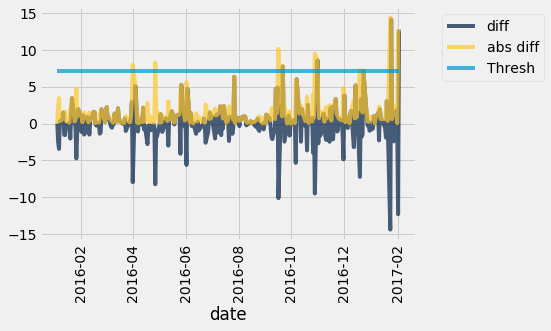

In [12]:
diff_table.plot(0)
plt.xticks(rotation=90)

(array([ 735995.,  736055.,  736116.,  736177.,  736238.,  736299.,  736361.]),
 <a list of 7 Text xticklabel objects>)

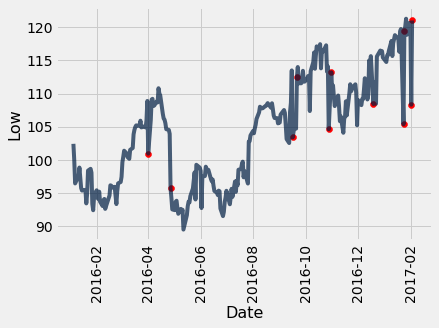

In [13]:
#Actual graph with incident points marked in Red. 
nasvizData.drop(1, 3, 4).plot(0)
plt.scatter(important_dates.column(0), important_dates.column(2), color = 'red')
plt.xticks(rotation=90)

In [14]:
# Extracting Relevant articles using the New York Times Article Search API. 
def article_extract(article):
    return {'Name': article['headline']['main'],
            'URL': article['web_url'],
            'Date-Time': article['pub_date'] if 'pub_date' in article else ''

    }

def article_search(term, begin, end):
    data_search = (requests.get
                   ("https://api.nytimes.com/svc/search/v2/articlesearch.json?api-key=28ec5f20ab074501b55d83ea93cec91b&q=%s&begin_date=%s&end_date=%s"%
                    (term, begin, end)))
    return article_extract(data_search.json()['response']['docs'][0])

In [15]:
#Example of what an Article Search Returns. 

article_search('apple', "20170809", "20170810")

{'Date-Time': '2017-08-09T09:13:41+0000',
 'Name': 'Google’s War Over the Sexes',
 'URL': 'https://www.nytimes.com/2017/08/09/opinion/google-women-memo.html'}

In [16]:
# Tuning the important_dates Table to fit the format used by the New York Times Article Search API. 

important_dates_tweaked = Table().with_columns("Date", important_dates.apply(getDate, 0), "High", important_dates.column("High"), "Low", important_dates.column("Low"), "Close", important_dates.column("Close"))
important_dates_tweaked

Date,High,Low,Close
20160401,110,100.928,109.99
20160427,98.71,95.68,97.82
20160916,116.13,103.37,114.925
20160921,113.989,112.44,113.55
20161028,115.21,104.61,113.72
20161031,114.23,113.2,113.54
20161219,117.38,108.415,116.64
20170123,120.81,105.36,120.08
20170124,120.1,119.5,119.97
20170201,130.49,108.313,128.75


In [17]:
#The Final Table after all the computation is finished. 

final = important_dates_tweaked.join('Date', nyData, 'Date').drop(5, 6, 7)
final

Date,High,Low,Close,NextDate
20160401,110,100.928,109.99,20160402
20160427,98.71,95.68,97.82,20160428
20160916,116.13,103.37,114.925,20160917
20160921,113.989,112.44,113.55,20160922
20161028,115.21,104.61,113.72,20161029
20161031,114.23,113.2,113.54,20161101
20161219,117.38,108.415,116.64,20161220
20170123,120.81,105.36,120.08,20170124
20170124,120.1,119.5,119.97,20170125
20170201,130.49,108.313,128.75,20170202


In [19]:
#The Articles recieved after implementing the API. 

head=[]
for i in np.arange(final.num_rows):
    head[len(head):] = [article_search(getCompany(company), final.column(0)[i], final.column(4)[i])]
    sleep(1)
head

[{'Date-Time': '2016-04-02T00:00:00Z',
  'Name': 'Moving CD-Ripped Music From the Computer to the iPad',
  'URL': 'https://www.nytimes.com/2016/04/02/technology/personaltech/moving-cd-ripped-music-from-the-computer-to-the-ipad.html'},
 {'Date-Time': '2016-04-28T00:00:00Z',
  'Name': 'Turning Down an OS X Upgrade',
  'URL': 'https://www.nytimes.com/2016/04/28/technology/personaltech/turning-down-an-os-x-upgrade.html'},
 {'Date-Time': '2016-09-16T06:08:22Z',
  'Name': 'Apple Tax Row Raises $2.1 Trillion Question for Forex Traders',
  'URL': 'https://www.nytimes.com/reuters/2016/09/16/business/16reuters-global-forex-tax.html'},
 {'Date-Time': '2016-09-21T04:00:00+0000',
  'Name': 'How Tesla and Apple Could Be Good for Each Other',
  'URL': 'https://www.nytimes.com/2016/09/21/business/dealbook/how-tesla-and-apple-could-be-good-for-each-other.html'},
 {'Date-Time': '2016-10-28T17:13:30+0000',
  'Name': 'Review: ‘To Pixar and Beyond’ Plumbs New Depth in Oft-Told Tale',
  'URL': 'https://www.

In [20]:
#Tabulation for the interactive plot. 

final_head = pd.DataFrame.from_dict(head)
headlines=make_array()
for i in np.arange(final.num_rows):
    headline= final_head.as_matrix(columns=final_head.columns[1:])[i][0]
    headlines= np.append(headlines, headline)
# final_head.iloc[:,1]
URLS=make_array()
for i in np.arange(final.num_rows):
    URL= final_head.as_matrix(columns=final_head.columns[1:])[i][1]
    URLS= np.append(URLS, URL)
final_head

,Date-Time,Name,URL
0,2016-04-02T00:00:00Z,Moving CD-Ripped Music From the Computer to th...,https://www.nytimes.com/2016/04/02/technology/...
1,2016-04-28T00:00:00Z,Turning Down an OS X Upgrade,https://www.nytimes.com/2016/04/28/technology/...
2,2016-09-16T06:08:22Z,Apple Tax Row Raises $2.1 Trillion Question fo...,https://www.nytimes.com/reuters/2016/09/16/bus...
3,2016-09-21T04:00:00+0000,How Tesla and Apple Could Be Good for Each Other,https://www.nytimes.com/2016/09/21/business/de...
4,2016-10-28T17:13:30+0000,Review: ‘To Pixar and Beyond’ Plumbs New Depth...,https://www.nytimes.com/2016/10/29/business/de...
5,2016-10-31T16:31:10+0000,Daily Report: Google’s Day in Europe’s Court H...,https://www.nytimes.com/2016/11/01/technology/...
6,2016-12-19T00:59:57+0000,"By Attacking the Press, Donald Trump May Be Do...",https://www.nytimes.com/2016/12/18/business/me...
7,2017-01-23T16:12:52+0000,Fighting iPhone Battery Life Blues,https://www.nytimes.com/2017/01/23/technology/...
8,2017-01-24T05:00:00+0000,"A Little Nostalgia, a Long Fork and Lots of Ch...",https://cooking.nytimes.com/recipes/1018557-sw...
9,2017-02-01T17:24:07+0000,"Daily Report: At Apple, Triumphs Amid Tribulat...",https://www.nytimes.com/2017/02/01/technology/...


In [21]:
#The Interactive Plot and URLs. 

import plotly.plotly as py
import plotly 
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='gaurav98m', api_key='9ZRh4HFPJ8wE5e5GBOzX')

# Create random data with numpy
# import numpy as np

# N = 500
# random_x = np.linspace(0, 1, N)
# random_y = np.random.randn(N)

# Create a trace
trace = go.Scatter(
    x = nasvizData.column(0),
    y = nasvizData.column(2)
#     hoverinfo='none'
)

trace2 = go.Scatter(
    x = important_dates.column(0),
    y = important_dates.column(2),
    mode='markers',
    name='Lines, Markers and Text',
    text=headlines,
    textposition='top'
)

data = [trace, trace2]

py.iplot(data, filename='basic-line')



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~gaurav98m/0 or inside your plot.ly account where it is named 'basic-line'


In [22]:
for url in URLS: 
    print(url)

https://www.nytimes.com/2016/04/02/technology/personaltech/moving-cd-ripped-music-from-the-computer-to-the-ipad.html
https://www.nytimes.com/2016/04/28/technology/personaltech/turning-down-an-os-x-upgrade.html
https://www.nytimes.com/reuters/2016/09/16/business/16reuters-global-forex-tax.html
https://www.nytimes.com/2016/09/21/business/dealbook/how-tesla-and-apple-could-be-good-for-each-other.html
https://www.nytimes.com/2016/10/29/business/dealbook/review-to-pixar-and-beyond-plumbs-new-depth-in-oft-told-tale.html
https://www.nytimes.com/2016/11/01/technology/daily-report-googles-day-in-europes-court-highlights-nature-of-new-tech.html
https://www.nytimes.com/2016/12/18/business/media/by-attacking-the-press-donald-trump-may-be-doing-it-a-favor.html
https://www.nytimes.com/2017/01/23/technology/personaltech/fighting-the-iphone-battery-blues.html
https://cooking.nytimes.com/recipes/1018557-sweet-gorgonzola-fondue
https://www.nytimes.com/2017/02/01/technology/daily-report-at-apple-triumphs